# 기상 예보데이터와 실제 관측 데이터 비교

## 1. 지하철역 위치정보를 기상청 격자(nx, ny) 로 변환
기상청 예보 데이터는 위도/경도(lat/lon)이 아닌 격자좌표계(nx,ny) 기준으로 제공되므로,
지하철역 위치를 예보 데이터와 연결하려면, 위도/경도 -> nx/ny 변환 작업선행 요구됨.

격자좌표 : 
| 항목 | 설명 |
|------|------|
| 좌표계 | LCC (Lambert Conformal Conic) 투영 기반 |
| 격자 간격 | 약 5km × 5km |
| 전체 격자 범위 | 동서 149 × 남북 253 (총 37,697개 격자) |
| 기준점 위경도 | 위도 38.0°, 경도 126.0° → nx: 43, ny: 136 |
| 사용 목적 | 위경도보다 간편한 기상자료 연계 계산 |

> 하나의 격자(nx, ny)는 약 5km 정방형 지역을 의미하며, 각 지점별 예보 및 관측 데이터가 이 단위로 제공됩니다.

### 1단계: 지하철역 위경도 데이터 불러오기

- 제공된 Excel 파일에서 지하철역의 이름(`name`), 위도(`point_y`), 경도(`point_x`) 정보를 불러온다.
- 이후 이 위경도를 기상청 격자(nx, ny)로 변환하기 위해 준비

In [1]:
import pandas as pd

# 엑셀 파일 경로
file_path = 'data/raw/지하철 위경도.xlsx'

# 엑셀 파일 불러오기
df = pd.read_excel(file_path)

# 주요 컬럼만 출력해보기
df[['name', 'point_y', 'point_x']].head()

,name,point_y,point_x
0,소요산,37.948747,127.061049
1,노포,35.283594,129.094817
2,안심,35.871249,128.733868
3,평동,35.124754,126.769559
4,반석,36.392128,127.314616


### 2단계: 위도/경도를 기상청 격자(nx, ny)로 변환하는 함수 정의

- 기상청 동네예보에서 사용하는 LCC(Lambert Conformal Conic) 투영 방식을 적용.
- 위도(`latitude`)와 경도(`longitude`)를 입력하면 해당 위치의 격자 좌표 `nx`, `ny`를 반환
- 변환 과정에서 소수점 처리를 위해 `+0.5 → int()` 방식으로 **반올림 처리**를 적용

In [2]:
import math

def convert_latlon_to_grid(lat, lon):
    # 기상청 표준 격자 변환 공식
    RE = 6371.00877  # 지구 반지름 (km)
    GRID = 5.0       # 격자 간격 (km)
    SLAT1 = 30.0     # 표준위도 1
    SLAT2 = 60.0     # 표준위도 2
    OLON = 126.0     # 기준점 경도
    OLAT = 38.0      # 기준점 위도
    XO = 43          # 기준점 X좌표
    YO = 136         # 기준점 Y좌표

    DEGRAD = math.pi / 180.0

    re = RE / GRID
    slat1 = SLAT1 * DEGRAD
    slat2 = SLAT2 * DEGRAD
    olon = OLON * DEGRAD
    olat = OLAT * DEGRAD

    sn = math.tan(math.pi * 0.25 + slat2 * 0.5) / math.tan(math.pi * 0.25 + slat1 * 0.5)
    sn = math.log(math.cos(slat1) / math.cos(slat2)) / math.log(sn)
    sf = math.tan(math.pi * 0.25 + slat1 * 0.5)
    sf = (sf ** sn) * math.cos(slat1) / sn
    ro = math.tan(math.pi * 0.25 + olat * 0.5)
    ro = re * sf / (ro ** sn)

    ra = math.tan(math.pi * 0.25 + lat * DEGRAD * 0.5)
    ra = re * sf / (ra ** sn)
    theta = lon * DEGRAD - olon
    if theta > math.pi:
        theta -= 2.0 * math.pi
    if theta < -math.pi:
        theta += 2.0 * math.pi
    theta *= sn

    x = ra * math.sin(theta) + XO + 0.5
    y = ro - ra * math.cos(theta) + YO + 0.5

    return int(x), int(y)

### 3단계: 지하철역 위경도에 격자 변환 함수 적용

- 앞에서 정의한 `convert_latlon_to_grid` 함수를 각 지하철역의 위도(`point_y`)와 경도(`point_x`)에 적용
- 각 지하철역에 대해 `nx`, `ny` 격자 좌표를 구하고, 새로운 컬럼으로 추가

In [3]:
# 함수를 적용하여 nx, ny 컬럼 추가
df[['nx', 'ny']] = df.apply(lambda row: pd.Series(convert_latlon_to_grid(row['point_y'], row['point_x'])), axis=1)

# 결과 확인
df[['name', 'point_y', 'point_x', 'nx', 'ny']].head()

,name,point_y,point_x,nx,ny
0,소요산,37.948747,127.061049,61,135
1,노포,35.283594,129.094817,98,78
2,안심,35.871249,128.733868,91,91
3,평동,35.124754,126.769559,57,74
4,반석,36.392128,127.314616,66,101


### 4단계: 예보 데이터와 지하철역 격자 매핑

- `daily_merged_forecast_2022_2024` 폴더 내의 예보 파일 중 하나(`2022010102.csv`)를 선택
- 이 파일은 특정 시각(예: 2022년 1월 1일 02시)의 격자별 예보 데이터를 포함
- 지하철역 데이터와 `nx`, `ny`를 기준으로 `merge`하여 각 역에 대한 해당 시각의 예보 정보를 가져옴

In [9]:
# 병합된 예보 데이터 불러오기 (이미 병합된 상태: 하루 모든 시간 포함)
forecast_df = pd.read_csv('daily_merged_forecast_2022_2024/2022/20220101.csv')

# 지하철역 데이터는 이미 df에 있음 (nx, ny 포함)
# 예보에 지하철역 이름 붙이기 (nx, ny 기준)
merged_df = pd.merge(forecast_df, df[['name', 'nx', 'ny']], on=['nx', 'ny'], how='inner')

# 확인: 예보 + 역명
merged_df[['년', '월', '일', '시각', 'name', 'TMP', 'REH', 'SKY', 'PTY', 'POP', 'PCP', 'WSD']].head()

,년,월,일,시각,name,TMP,REH,SKY,PTY,POP,PCP,WSD
0,2022,1,1,2,인천공항2터미널,-99.0,-99.0,1.0,0.0,-99.0,-99.0,9.2
1,2022,1,1,2,공항화물청사,-8.0,70.0,1.0,0.0,0.0,0.0,1.3
2,2022,1,1,2,인천공항1터미널,-8.0,70.0,1.0,0.0,0.0,0.0,1.3
3,2022,1,1,2,운서,-10.0,75.0,1.0,0.0,0.0,0.0,1.3
4,2022,1,1,2,영종,-99.0,-99.0,3.0,0.0,-99.0,-99.0,2.8


In [14]:
import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='Malgun Gothic')

# 음수 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

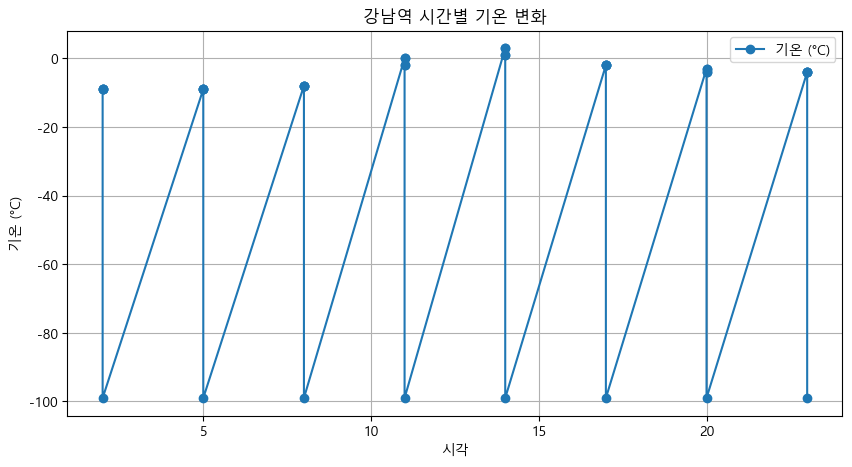

In [15]:
import matplotlib.pyplot as plt

# 예시: 강남역의 시간별 기온
station_name = '강남'
plot_df = merged_df[merged_df['name'].str.contains(station_name)]

plt.figure(figsize=(10, 5))
plt.plot(plot_df['시각'], plot_df['TMP'], marker='o', label='기온 (°C)')
plt.title(f"{station_name}역 시간별 기온 변화")
plt.xlabel('시각')
plt.ylabel('기온 (°C)')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
# '강남'이라는 정확한 역명만 필터링
station_temp_df = merged_df[merged_df['name'] == '강남'][['년', '월', '일', '시각', 'name', 'TMP']].sort_values(by='시각')

In [20]:
station_temp_df

,년,월,일,시각,name,TMP
454,2022,1,1,2,강남,-9.0
455,2022,1,1,2,강남,-9.0
1179,2022,1,1,5,강남,-9.0
1180,2022,1,1,5,강남,-9.0
1904,2022,1,1,8,강남,-8.0
1905,2022,1,1,8,강남,-8.0
2629,2022,1,1,11,강남,0.0
2630,2022,1,1,11,강남,0.0
3354,2022,1,1,14,강남,3.0
3355,2022,1,1,14,강남,3.0


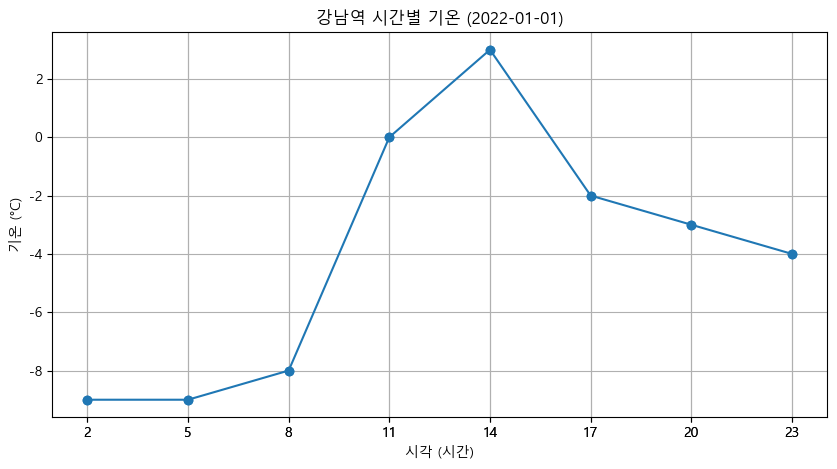

In [21]:
import matplotlib.pyplot as plt

# 시각과 기온을 그래프로 표시
plt.figure(figsize=(10, 5))
plt.plot(station_temp_df['시각'], station_temp_df['TMP'], marker='o', linestyle='-')

plt.title('강남역 시간별 기온 (2022-01-01)')
plt.xlabel('시각 (시간)')
plt.ylabel('기온 (°C)')
plt.grid(True)
plt.xticks(station_temp_df['시각'])  # 시각 레이블 맞춤
plt.show()


### 날짜 + 시각을 datetime으로 변환 후 시계열 그래프 그리기

- `년`, `월`, `일`, `시각` 정보를 `datetime` 포맷으로 변환
- 시계열 분석을 위해 x축에 실제 날짜시간을 사용해 기온 추세를 시각화

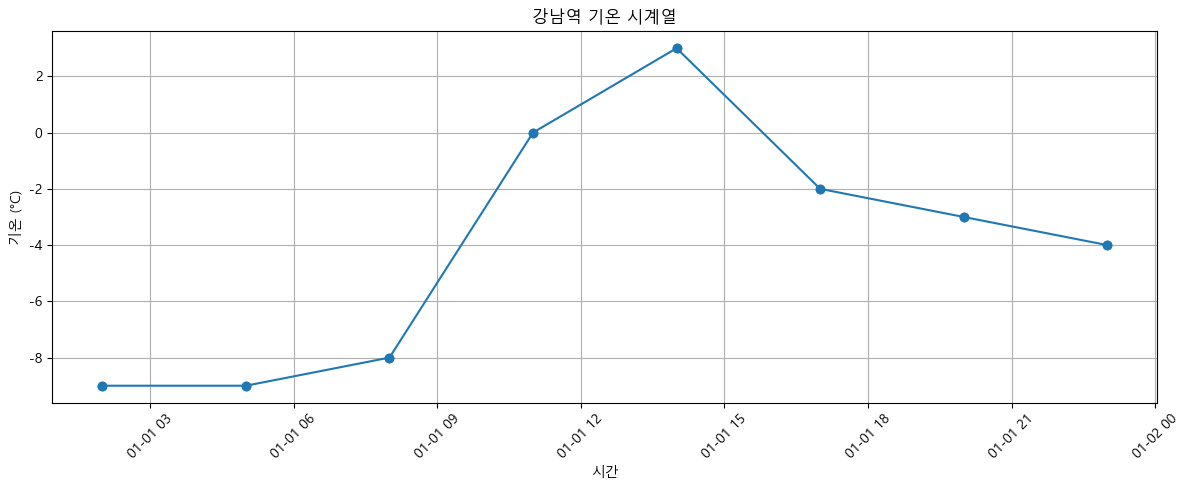

In [22]:
# datetime 컬럼 만들기
station_temp_df['datetime'] = pd.to_datetime(
    station_temp_df[['년', '월', '일', '시각']].rename(columns={'년':'year', '월':'month', '일':'day', '시각':'hour'})
)

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(station_temp_df['datetime'], station_temp_df['TMP'], marker='o', linestyle='-')

plt.title('강남역 기온 시계열')
plt.xlabel('시간')
plt.ylabel('기온 (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 여러 날짜 예보 파일 반복 처리 및 강남역 기온 시계열 분석

- `daily_merged_forecast_2022_2024/2022` 폴더 아래의 모든 날짜별 예보 파일(`20220101.csv`, `20220102.csv`, ...)을 반복 처리
- 각 파일에서 `nx`, `ny` 기준으로 지하철역과 병합하고, 역명이 `'강남'`인 데이터만 추출
- `datetime` 컬럼을 생성하고 전체 데이터를 시계열로 연결

C:\Users\somee\AppData\Local\Temp\ipykernel_26324\3276027190.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gangnam['datetime'] = pd.to_datetime(
C:\Users\somee\AppData\Local\Temp\ipykernel_26324\3276027190.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gangnam['datetime'] = pd.to_datetime(
C:\Users\somee\AppData\Local\Temp\ipykernel_26324\3276027190.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

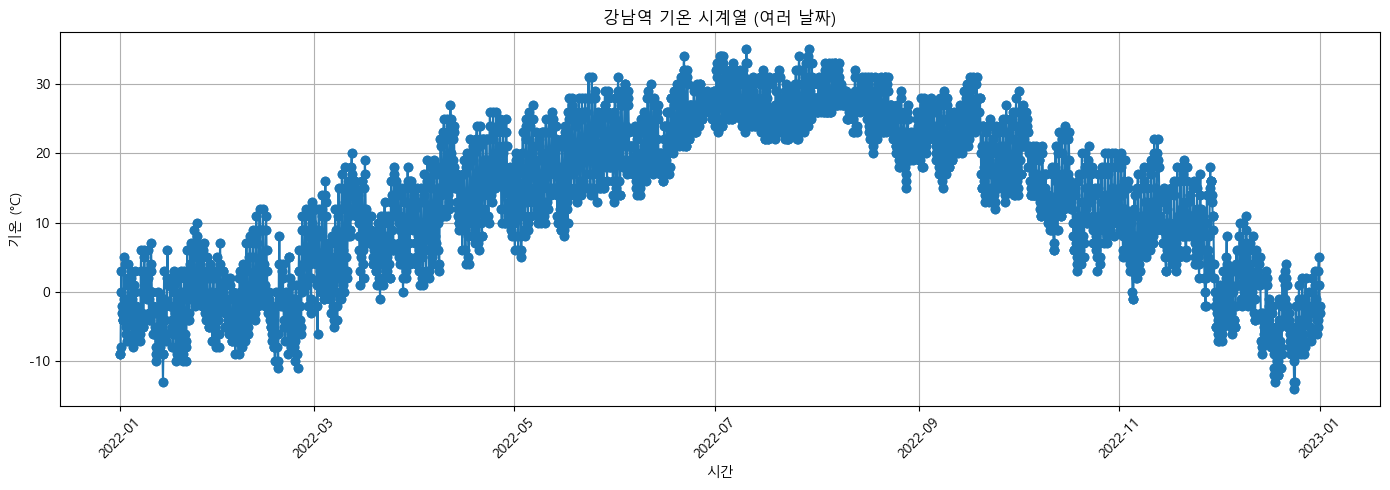

In [23]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 경로 지정
data_dir = 'data/daily_merged_forecast_2022_2024/2022'
file_list = sorted(glob(os.path.join(data_dir, '*.csv')))

# 결과 저장 리스트
result_list = []

# 반복 처리
for file_path in file_list:
    try:
        forecast = pd.read_csv(file_path)
        # 지하철역 병합 (df는 미리 정의되어 있어야 함)
        merged = pd.merge(forecast, df[['name', 'nx', 'ny']], on=['nx', 'ny'], how='inner')
        # 강남역 필터링
        gangnam = merged[merged['name'] == '강남']
        # datetime 생성
        gangnam['datetime'] = pd.to_datetime(
            gangnam[['년', '월', '일', '시각']].rename(columns={'년':'year', '월':'month', '일':'day', '시각':'hour'})
        )
        result_list.append(gangnam[['datetime', 'TMP']])
    except Exception as e:
        print(f"❌ 파일 처리 오류: {file_path} / {e}")

# 전체 병합
full_temp_df = pd.concat(result_list).sort_values(by='datetime').reset_index(drop=True)

# 시계열 시각화
plt.figure(figsize=(14, 5))
plt.plot(full_temp_df['datetime'], full_temp_df['TMP'], marker='o', linestyle='-')
plt.title('강남역 기온 시계열 (여러 날짜)')
plt.xlabel('시간')
plt.ylabel('기온 (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
import plotly.graph_objs as go
import plotly.io as pio

# 기본 템플릿 설정 (선택)
pio.templates.default = "plotly_white"

# 그래프 객체 생성
fig = go.Figure()

# 시계열 데이터 추가
fig.add_trace(go.Scatter(
    x=full_temp_df['datetime'],
    y=full_temp_df['TMP'],
    mode='lines+markers',
    name='기온',
    line=dict(color='royalblue'),
    marker=dict(size=5)
))

# 레이아웃 설정
fig.update_layout(
    title='강남역 시간별 기온 시계열 (인터랙티브)',
    xaxis_title='시간',
    yaxis_title='기온 (°C)',
    xaxis=dict(rangeslider_visible=True),  # 아래 범위 슬라이더 추가
    hovermode='x unified',
    template='plotly_white',
    height=500
)

# 그래프 출력
fig.show()


In [25]:
df

,id,name,address,roadAddress,displayCode,displayName,city_id,city_name,point_x,point_y,routeType_id,routeType_name,transfers,nx,ny
0,100,소요산,경기도 동두천시 상봉암동 126-3,경기도 동두천시 평화로 2925,100,소요산역,1000,서울,127.061049,37.948747,1,1호선,NaN,61,135
1,70134,노포,부산광역시 금정구 노포동 133,부산광역시 금정구 중앙대로 2238,134,노포역,7000,부산,129.094817,35.283594,71,1호선,NaN,98,78
2,40146,안심,대구광역시 동구 괴전동 536-1,대구광역시 동구 안심로 455,146,안심역,4000,대구,128.733868,35.871249,41,1호선,NaN,91,91
3,50129,평동,광주광역시 광산구 월전동 51-23,광주광역시 광산구 평동로 870,119,평동역,5000,광주,126.769559,35.124754,51,1호선,NaN,57,74
4,30122,반석,대전광역시 유성구 반석동 685,대전광역시 유성구 북유성대로 303,122,반석역,3000,대전,127.314616,36.392128,31,1호선,NaN,66,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,1411,아산,충청남도 아산시 배방읍 장재리 268,충청남도 아산시 배방읍 희망로 90,P172,아산역,1000,서울,127.104573,36.792118,1,1호선,NaN,62,110
1054,1412,탕정,충청남도 아산시 탕정면 매곡리 472-1,충청남도 아산시 탕정면 매곡중앙6로 11,P173,탕정역,1000,서울,127.084638,36.788270,1,1호선,NaN,62,110
1055,1413,배방,충청남도 아산시 배방읍 구령리 148-2,충청남도 아산시 배방읍 온천대로 1967,P174,배방역,1000,서울,127.052842,36.777592,1,1호선,NaN,61,110
1056,1415,온양온천,충청남도 아산시 온천동 56-9,충청남도 아산시 온천대로 1496,P176,온양온천역,1000,서울,127.003178,36.780541,1,1호선,NaN,60,110


## 2. 예보 vs 관측 데이터 비교 분석

### 1단계: 라이브러리 및 매핑 파일 로드
- 예보 데이터: daily_merged_forecast_2022_2024/2022~2024
- 관측 데이터: 기상관측.csv (2022-2024 기상관측파일)
- 매핑 데이터:
  - 지하철역 ↔ 격자(nx, ny)
  - 지하철역 ↔ 관측지점명

In [28]:
import pandas as pd
from glob import glob
import os

# 경로 설정
forecast_dir = "data/daily_merged_forecast_2022_2024/2022"
obs_path = "data/raw/기상관측.csv"
nxny_path = "data/지하철역_nxy.csv"
station_map_path = "data/지하철역_관측지점_매핑완료.csv"

# 데이터 로드
forecast_files = sorted(glob(os.path.join(forecast_dir, "*.csv")))
obs_df = pd.read_csv(obs_path)
nxny_df = pd.read_csv(nxny_path)
station_map_df = pd.read_csv(station_map_path)

In [31]:
obs_df
nxny_df
station_map_df

,id,name,address,roadAddress,displayCode,displayName,city_id,city_name,point_x,point_y,routeType_id,routeType_name,transfers,지점명
0,100,소요산,경기도 동두천시 상봉암동 126-3,경기도 동두천시 평화로 2925,100,소요산역,1000,서울,127.061049,37.948747,1,1호선,NaN,연천청산
1,101,동두천,경기도 동두천시 동두천동 245-210,경기도 동두천시 평화로 2687,101,동두천역,1000,서울,127.054850,37.927574,1,1호선,NaN,동두천
2,102,보산,경기도 동두천시 보산동 422,경기도 동두천시 평화로 2539,102,보산역,1000,서울,127.057163,37.914265,1,1호선,NaN,동두천
3,103,동두천중앙,경기도 동두천시 생연동 726-3,경기도 동두천시 동두천로 228,103,동두천중앙역,1000,서울,127.056421,37.901682,1,1호선,NaN,동두천
4,104,지행,경기도 동두천시 지행동 424-1,경기도 동두천시 평화로 2285,104,지행역,1000,서울,127.055751,37.892370,1,1호선,NaN,동두천
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,1403,평택지제,경기도 평택시 지제동 141-1,경기도 평택시 경기대로 777,P164,평택지제역,1000,서울,127.070471,37.018872,1,1호선,NaN,평택
654,1713,보평,경기도 용인시 처인구 유방동 276-1,경기도 용인시 처인구 경안천로 313,Y122,보평역,1000,서울,127.218465,37.259028,107,에버라인,NaN,용인
655,1404,평택,경기도 평택시 평택동 185-568,경기도 평택시 평택로 51,P165,평택역,1000,서울,127.085812,36.990256,1,1호선,NaN,평택
656,1714,둔전,경기도 용인시 처인구 포곡읍 둔전리 406-93,경기도 용인시 처인구 포곡읍 포곡로 70,Y123,둔전역,1000,서울,127.213625,37.267154,107,에버라인,NaN,용인


### 2단계: 관측 데이터 전처리
- '일시' 컬럼을 datetime 타입으로 변환
- 분석에 필요한 컬럼(지점명, 기온, 습도 등)만 추출
- 이후 예보 데이터와 시간 기준 병합할 수 있도록 준비

In [32]:
# datetime 변환
obs_df['datetime'] = pd.to_datetime(obs_df['일시'])

# 필요한 컬럼만 추출
obs_df = obs_df[['지점명', 'datetime', '기온(°C)', '습도(%)']].copy()

# 결측치 제거 (원한다면)
obs_df = obs_df.dropna(subset=['기온(°C)'])

# 확인
obs_df.head()

,지점명,datetime,기온(°C),습도(%)
0,강남,2022-01-01 00:00:00,-6.5,31.0
1,강남,2022-02-01 01:00:00,1.3,71.0
2,강남,2022-02-01 02:00:00,0.7,59.0
3,강남,2022-02-01 03:00:00,0.7,55.0
4,강남,2022-02-01 04:00:00,-1.4,89.0


### 3단계: 예보 데이터 연도별 순차 로드 및 특정 역 예보 추출
- 지정한 역 이름을 기준으로, 해당 역의 nx, ny를 가져옴
- 2022년 예보 파일을 날짜별로 불러오며 nx, ny에 해당하는 예보 데이터만 누적
- TMP(기온), REH(습도) 중심 시계열로 구성

In [33]:
def get_forecast_for_station(station_name, forecast_files, nxny_df):
    # 역명 기준으로 nx, ny 조회
    nxny_row = nxny_df[nxny_df['name'].str.contains(station_name)].iloc[0]
    nx, ny = nxny_row['nx'], nxny_row['ny']

    records = []

    for file_path in forecast_files:
        try:
            df = pd.read_csv(file_path)
            df = df[(df['nx'] == nx) & (df['ny'] == ny)].copy()
            df['datetime'] = pd.to_datetime(df[['년', '월', '일', '시각']].rename(
                columns={'년': 'year', '월': 'month', '일': 'day', '시각': 'hour'}
            ))
            df = df[['datetime', 'TMP', 'REH']].copy()
            records.append(df)
        except Exception as e:
            print(f"⚠️ {file_path} 처리 중 오류: {e}")

    # 누적 후 정렬
    result = pd.concat(records).sort_values('datetime').reset_index(drop=True)
    result.rename(columns={'TMP': '예보기온(°C)', 'REH': '예보습도(%)'}, inplace=True)
    return result


In [34]:
forecast_df = get_forecast_for_station("강남", forecast_files, nxny_df)

### 4단계: 예보 vs 관측 병합 및 기온차 계산
- 동일한 datetime 기준으로 예보와 관측 데이터를 병합
- 기온(°C), 습도(%) 각각의 차이를 계산하여 새로운 컬럼으로 추가
- 병합은 'inner join'으로 예보와 관측이 모두 존재하는 시각만 사용

In [36]:
def compare_forecast_and_observation(forecast_df, obs_df, station_name, station_map_df):
    # 매핑된 관측소명 확인
    stn_name = station_map_df[station_map_df['name'].str.contains(station_name)].iloc[0]['지점명']
    
    # 관측소 시계열 필터링
    obs_filtered = obs_df[obs_df['지점명'] == stn_name].copy()

    # 병합
    merged = pd.merge(forecast_df, obs_filtered, on='datetime', how='inner')
    
    # 오차 계산
    merged['기온차(예보-관측)'] = merged['예보기온(°C)'] - merged['기온(°C)']
    merged['습도차(예보-관측)'] = merged['예보습도(%)'] - merged['습도(%)']
    
    # 역명, 관측소명 추가
    merged['역명'] = station_name
    merged['관측지점명'] = stn_name
    
    return merged

In [37]:
comparison_df = compare_forecast_and_observation(forecast_df, obs_df, "강남", station_map_df)
comparison_df.head()

,datetime,예보기온(°C),예보습도(%),지점명,기온(°C),습도(%),기온차(예보-관측),습도차(예보-관측),역명,관측지점명
0,2022-02-01 02:00:00,-2.0,80.0,강남,0.7,59.0,-2.7,21.0,강남,강남
1,2022-02-01 05:00:00,-3.0,70.0,강남,-1.4,94.0,-1.6,-24.0,강남,강남
2,2022-02-01 08:00:00,-1.0,65.0,강남,-1.4,79.0,0.4,-14.0,강남,강남
3,2022-02-01 11:00:00,3.0,50.0,강남,0.0,65.0,3.0,-15.0,강남,강남
4,2022-02-01 14:00:00,3.0,45.0,강남,0.7,58.0,2.3,-13.0,강남,강남


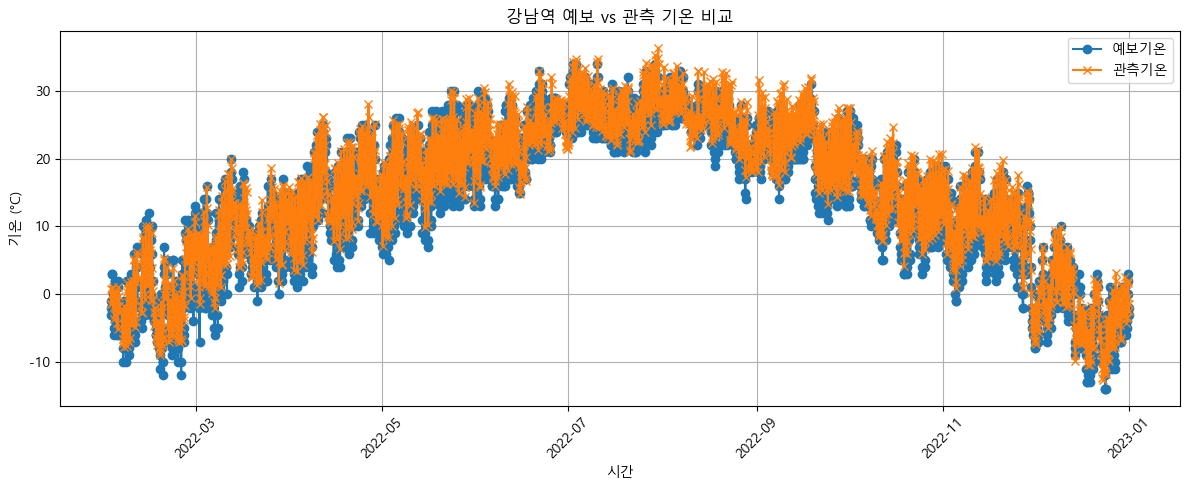

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(comparison_df['datetime'], comparison_df['예보기온(°C)'], label='예보기온', marker='o')
plt.plot(comparison_df['datetime'], comparison_df['기온(°C)'], label='관측기온', marker='x')
plt.title('강남역 예보 vs 관측 기온 비교')
plt.xlabel('시간')
plt.ylabel('기온 (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### MAE(Mean Absolute Error) RMSE(Root Mean Squared Error)
예시 ) 강남역 -
MAE : 1.94°C,
RMSE : 2.35°C

> 강남역에서의 평균적으로 1.94도정도 틀리고, 큰 오차까지 고려했을 경우의 평균 오차는 2.35도 정도이다.

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = comparison_df['기온(°C)']
y_pred = comparison_df['예보기온(°C)']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}°C")
print(f"RMSE: {rmse:.2f}°C")

MAE: 1.94°C
RMSE: 2.35°C


## 3. 거리별 예보 정확도 차이 분석 (하지마)
### ✅ 거리 계산 방식

- `geopy.distance.geodesic()` 함수를 사용하여 거리 계산
- 위도/경도 좌표 간의 지구 곡률을 고려한 최단 거리(km)를 반환합니다.

```python
from geopy.distance import geodesic

# 강남역과 서울관측소 사이 거리 계산 예시
역_좌표 = (37.4979, 127.0276)
관측소_좌표 = (37.5714, 126.9658)

거리_km = geodesic(역_좌표, 관측소_좌표).km
print(f"거리: {거리_km:.2f} km")

In [44]:
from geopy.distance import geodesic

역_좌표 = (37.4979, 127.0276)       # 예: 강남역
관측소_좌표 = (37.5714, 126.9658)   # 예: 서울관측소

거리_km = geodesic(역_좌표, 관측소_좌표).km
print(f"거리: {거리_km:.2f} km")

거리: 9.82 km


### 1. 지하철역-관측소 간 거리 계산

- 각 지하철역의 위도/경도와 해당 관측소의 위도/경도를 이용하여 거리(km)를 계산
- 거리 계산에는 `geopy.distance.geodesic()` 함수를 사용
- 계산된 거리 정보는 예보 정확도(MAE 등)와의 상관관계 분석에 활용

In [54]:
from geopy.distance import geodesic

# 파일 로드
map_df = pd.read_csv("data/지하철역_관측지점_매핑완료.csv")
station_meta_df = pd.read_csv("data/raw/META_관측지점정보_20250530131322.csv", encoding="cp949")

# 관측소 위치 붙이기
merged_df = pd.merge(map_df, station_meta_df[['지점명', '위도', '경도']], on='지점명', how='left')

# 거리 계산
merged_df['거리(km)'] = merged_df.apply(
    lambda row: geodesic((row['point_y'], row['point_x']), (row['위도'], row['경도'])).km,
    axis=1
)

# 결과 미리보기
merged_df[['name', '지점명', '거리(km)']].head()

,name,지점명,거리(km)
0,소요산,연천청산,4.691940
1,소요산,연천청산,4.691940
2,소요산,연천청산,8.759289
3,동두천,동두천,3.236879
4,보산,동두천,1.754724


# 4. 관측소 거리와 예보 정확도 상관관계 분석

## 거리 vs 예보 정확도(MAE) 비교

- 각 역별로 예보와 관측 데이터를 병합해 MAE, RMSE 계산
- 앞서 계산한 거리(km)와 병합하여 분석

In [ ]:
import pandas as pd
import glob

# 경로에 있는 모든 CSV 불러오기
forecast_files = glob.glob("data/daily_merged_forecast_2022_2024/2022/*.csv")
forecast_all_df = pd.concat([pd.read_csv(f) for f in forecast_files], ignore_index=True) # 예보 데이터 병합합

In [62]:
forecast_all_df['datetime'] = pd.to_datetime(forecast_all_df[['년', '월', '일', '시각']].rename(
    columns={'년': 'year', '월': 'month', '일': 'day', '시각': 'hour'}
))
forecast_all_df = forecast_all_df.sort_values(by=['nx', 'ny', 'datetime']).reset_index(drop=True)

In [63]:
# dict 구조로 변환: {(nx, ny): DataFrame}
forecast_by_grid = {
    (nx, ny): group.drop(columns=['년', '월', '일', '시각'])
    for (nx, ny), group in forecast_all_df.groupby(['nx', 'ny'])
}

In [64]:
def get_forecast_for_station_by_grid(station_name, nxny_df, forecast_by_grid):
    row = nxny_df[nxny_df['name'].str.contains(station_name)].iloc[0]
    key = (row['nx'], row['ny'])

    if key not in forecast_by_grid:
        raise ValueError(f"{station_name} (nx={key[0]}, ny={key[1]}) → 예보 누락")

    df = forecast_by_grid[key].copy()
    df = df[['datetime', 'TMP', 'REH']].rename(columns={'TMP': '예보기온(°C)', 'REH': '예보습도(%)'})
    return df


In [65]:
forecast_all_df

,nx,ny,PCP,POP,PTY,REH,SKY,TMP,WSD,년,월,일,시각,datetime
0,50,119,-99.0,-99.0,0.0,-99.0,1.0,-99.0,5.9,2022,1,1,2,2022-01-01 02:00:00
1,50,119,-99.0,-99.0,0.0,-99.0,1.0,-99.0,5.2,2022,1,1,5,2022-01-01 05:00:00
2,50,119,-99.0,-99.0,0.0,-99.0,1.0,-99.0,4.1,2022,1,1,8,2022-01-01 08:00:00
3,50,119,-99.0,-99.0,0.0,-99.0,1.0,-99.0,2.7,2022,1,1,11,2022-01-01 11:00:00
4,50,119,-99.0,-99.0,0.0,-99.0,3.0,-99.0,0.7,2022,1,1,14,2022-01-01 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843008,66,135,-99.0,-99.0,0.0,-99.0,4.0,-99.0,6.0,2022,12,31,11,2022-12-31 11:00:00
843009,66,135,-99.0,-99.0,0.0,-99.0,1.0,-99.0,7.5,2022,12,31,14,2022-12-31 14:00:00
843010,66,135,-99.0,-99.0,0.0,-99.0,1.0,-99.0,7.7,2022,12,31,17,2022-12-31 17:00:00
843011,66,135,-99.0,-99.0,0.0,-99.0,3.0,-99.0,7.0,2022,12,31,20,2022-12-31 20:00:00


In [66]:
#역별 forecast 추출 (forecast_all_df)
def get_forecast_for_station(station_name, nxny_df, forecast_all_df):
    row = nxny_df[nxny_df['name'].str.contains(station_name)].iloc[0]
    nx, ny = row['nx'], row['ny']
    df = forecast_all_df[(forecast_all_df['nx'] == nx) & (forecast_all_df['ny'] == ny)].copy()
    df['datetime'] = pd.to_datetime(df[['년', '월', '일', '시각']].rename(
        columns={'년': 'year', '월': 'month', '일': 'day', '시각': 'hour'}
    ))
    return df[['datetime', 'TMP', 'REH']].rename(columns={'TMP': '예보기온(°C)', 'REH': '예보습도(%)'})


In [68]:
# 예보 관측 비교
def compare_forecast_and_observation(forecast_df, obs_df, station_name, station_map_df):
    stn_name = station_map_df[station_map_df['name'].str.contains(station_name)].iloc[0]['지점명']
    obs_filtered = obs_df[obs_df['지점명'] == stn_name].copy()

    merged = pd.merge(forecast_df, obs_filtered, on='datetime', how='inner')
    if merged.empty:
        raise ValueError(f"{station_name} → 병합된 예보/관측 데이터 없음")

    merged['기온차(예보-관측)'] = merged['예보기온(°C)'] - merged['기온(°C)']
    merged['역명'] = station_name
    merged['관측지점명'] = stn_name
    return merged


In [72]:
# nx, ny 좌표 파일 불러오기
nxny_df = pd.read_csv("data/지하철역_nxy.csv", encoding="utf-8-sig")

# 병합: merged_df + nx, ny
merged_df = pd.merge(merged_df, nxny_df[['name', 'nx', 'ny']], on='name', how='left')


In [96]:
merged_df

,id,name,address,roadAddress,displayCode,displayName,city_id,city_name,point_x,point_y,routeType_id,routeType_name,transfers,지점명,위도,경도,거리(km),nx,ny
0,100,소요산,경기도 동두천시 상봉암동 126-3,경기도 동두천시 평화로 2925,100,소요산역,1000,서울,127.061049,37.948747,1,1호선,NaN,연천청산,37.9900,127.0727,4.691940,61,135
1,100,소요산,경기도 동두천시 상봉암동 126-3,경기도 동두천시 평화로 2925,100,소요산역,1000,서울,127.061049,37.948747,1,1호선,NaN,연천청산,37.9900,127.0727,4.691940,61,135
2,100,소요산,경기도 동두천시 상봉암동 126-3,경기도 동두천시 평화로 2925,100,소요산역,1000,서울,127.061049,37.948747,1,1호선,NaN,연천청산,38.0265,127.0781,8.759289,61,135
3,101,동두천,경기도 동두천시 동두천동 245-210,경기도 동두천시 평화로 2687,101,동두천역,1000,서울,127.054850,37.927574,1,1호선,NaN,동두천,37.8991,127.0628,3.236879,61,135
4,102,보산,경기도 동두천시 보산동 422,경기도 동두천시 평화로 2539,102,보산역,1000,서울,127.057163,37.914265,1,1호선,NaN,동두천,37.8991,127.0628,1.754724,61,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,1715,전대.에버랜드,경기도 용인시 처인구 포곡읍 전대리 192-38,경기도 용인시 처인구 포곡읍 에버랜드로 143,Y124,전대.에버랜드역,1000,서울,127.219532,37.285388,107,에버라인,NaN,용인,37.2701,127.2218,1.708589,64,121
3500,1715,전대.에버랜드,경기도 용인시 처인구 포곡읍 전대리 192-38,경기도 용인시 처인구 포곡읍 에버랜드로 143,Y124,전대.에버랜드역,1000,서울,127.219532,37.285388,107,에버라인,NaN,용인,37.2701,127.2218,1.708589,64,121
3501,1715,전대.에버랜드,경기도 용인시 처인구 포곡읍 전대리 192-38,경기도 용인시 처인구 포곡읍 에버랜드로 143,Y124,전대.에버랜드역,1000,서울,127.219532,37.285388,107,에버라인,NaN,용인,37.2716,127.2249,1.602581,64,121
3502,1715,전대.에버랜드,경기도 용인시 처인구 포곡읍 전대리 192-38,경기도 용인시 처인구 포곡읍 에버랜드로 143,Y124,전대.에버랜드역,1000,서울,127.219532,37.285388,107,에버라인,NaN,용인,37.2500,127.2000,4.292582,64,121


In [92]:
print(forecast_df.columns)
print(obs_df_station.columns)

Index(['nx', 'ny', 'PCP', 'POP', 'PTY', 'REH', 'SKY', 'TMP', 'WSD', '년', '월',
       '일', '시각', 'datetime'],
      dtype='object')
Index(['지점명', 'datetime', 'TMP_obs', '습도(%)'], dtype='object')


In [108]:
# 관측데이터 불러오기
obs_df = pd.read_csv("data/raw/기상관측.csv", encoding="utf-8-sig")

In [107]:
forecast_all_df # 2022년도 전체 예보 데이터

,nx,ny,PCP,POP,PTY,REH,SKY,TMP,WSD,년,월,일,시각,datetime
0,50,119,-99.0,-99.0,0.0,-99.0,1.0,-99.0,5.9,2022,1,1,2,2022-01-01 02:00:00
1,50,119,-99.0,-99.0,0.0,-99.0,1.0,-99.0,5.2,2022,1,1,5,2022-01-01 05:00:00
2,50,119,-99.0,-99.0,0.0,-99.0,1.0,-99.0,4.1,2022,1,1,8,2022-01-01 08:00:00
3,50,119,-99.0,-99.0,0.0,-99.0,1.0,-99.0,2.7,2022,1,1,11,2022-01-01 11:00:00
4,50,119,-99.0,-99.0,0.0,-99.0,3.0,-99.0,0.7,2022,1,1,14,2022-01-01 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843008,66,135,-99.0,-99.0,0.0,-99.0,4.0,-99.0,6.0,2022,12,31,11,2022-12-31 11:00:00
843009,66,135,-99.0,-99.0,0.0,-99.0,1.0,-99.0,7.5,2022,12,31,14,2022-12-31 14:00:00
843010,66,135,-99.0,-99.0,0.0,-99.0,1.0,-99.0,7.7,2022,12,31,17,2022-12-31 17:00:00
843011,66,135,-99.0,-99.0,0.0,-99.0,3.0,-99.0,7.0,2022,12,31,20,2022-12-31 20:00:00


In [113]:
#관측 데이터
obs_df

,지점,지점명,일시,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,400,강남,2022-01-01 00:00,-6.5,NaN,1.3,0.0,31.0
1,400,강남,2022-02-01 01:00,1.3,136.7,3.1,0.0,71.0
2,400,강남,2022-02-01 02:00,0.7,140.1,1.9,0.0,59.0
3,400,강남,2022-02-01 03:00,0.7,188.7,1.4,0.0,55.0
4,400,강남,2022-02-01 04:00,-1.4,206.9,1.3,0.0,89.0
...,...,...,...,...,...,...,...,...
687623,889,현충원,2024-12-31 19:00,1.1,NaN,1.7,0.0,44.0
687624,889,현충원,2024-12-31 20:00,-0.2,NaN,0.9,0.0,49.0
687625,889,현충원,2024-12-31 21:00,-3.3,NaN,0.7,0.0,63.0
687626,889,현충원,2024-12-31 22:00,-3.5,NaN,0.7,0.0,67.0


In [115]:
import pandas as pd
import math

# 1. 관측소 메타 정보 불러오기
meta_path = "data/raw/META_관측지점정보_20250530131322.csv"
station_meta_df = pd.read_csv(meta_path, encoding='euc-kr')

# 2. 필요한 컬럼만 추출
station_meta_df = station_meta_df[['지점', '지점명', '위도', '경도']].dropna()

# 3. 위경도 → nx, ny 변환 함수 정의
def convert_latlon_to_grid(lat, lon):
    RE = 6371.00877  # 지구 반지름 (km)
    GRID = 5.0       # 격자 간격 (km)
    SLAT1 = 30.0
    SLAT2 = 60.0
    OLON = 126.0
    OLAT = 38.0
    XO = 43
    YO = 136

    DEGRAD = math.pi / 180.0

    re = RE / GRID
    slat1 = SLAT1 * DEGRAD
    slat2 = SLAT2 * DEGRAD
    olon = OLON * DEGRAD
    olat = OLAT * DEGRAD

    sn = math.tan(math.pi * 0.25 + slat2 * 0.5) / math.tan(math.pi * 0.25 + slat1 * 0.5)
    sn = math.log(math.cos(slat1) / math.cos(slat2)) / math.log(sn)
    sf = math.tan(math.pi * 0.25 + slat1 * 0.5)
    sf = (sf ** sn) * math.cos(slat1) / sn
    ro = math.tan(math.pi * 0.25 + olat * 0.5)
    ro = re * sf / (ro ** sn)

    ra = math.tan(math.pi * 0.25 + lat * DEGRAD * 0.5)
    ra = re * sf / (ra ** sn)
    theta = lon * DEGRAD - olon
    if theta > math.pi:
        theta -= 2.0 * math.pi
    if theta < -math.pi:
        theta += 2.0 * math.pi
    theta *= sn

    x = ra * math.sin(theta) + XO + 0.5
    y = ro - ra * math.cos(theta) + YO + 0.5

    return int(x), int(y)

# 4. nx, ny 컬럼 계산
station_meta_df[['nx', 'ny']] = station_meta_df.apply(
    lambda row: pd.Series(convert_latlon_to_grid(row['위도'], row['경도'])), axis=1
)

# 5. obs_df와 병합 (obs_df에 '지점명' 컬럼이 있어야 함)
obs_df = pd.merge(obs_df, station_meta_df[['지점명', 'nx', 'ny']], on='지점명', how='left')

# 결과 미리보기
print(obs_df.head())


    지점 지점명                일시  기온(°C)  풍향(deg)  풍속(m/s)  강수량(mm)  습도(%)    nx  \
0  400  강남  2022-01-01 00:00    -6.5      NaN      1.3      0.0   31.0  62.0   
1  400  강남  2022-01-01 00:00    -6.5      NaN      1.3      0.0   31.0  62.0   
2  400  강남  2022-01-01 00:00    -6.5      NaN      1.3      0.0   31.0  62.0   
3  400  강남  2022-01-01 00:00    -6.5      NaN      1.3      0.0   31.0  61.0   
4  400  강남  2022-01-01 00:00    -6.5      NaN      1.3      0.0   31.0  61.0   

      ny  
0  125.0  
1  125.0  
2  125.0  
3  126.0  
4  125.0  


In [118]:
obs_df

,지점,지점명,일시,TMP_obs,풍향(deg),풍속(m/s),강수량(mm),습도(%),nx,ny
0,400,강남,2022-01-01 00:00,-6.5,NaN,1.3,0.0,31.0,62.0,125.0
1,400,강남,2022-01-01 00:00,-6.5,NaN,1.3,0.0,31.0,62.0,125.0
2,400,강남,2022-01-01 00:00,-6.5,NaN,1.3,0.0,31.0,62.0,125.0
3,400,강남,2022-01-01 00:00,-6.5,NaN,1.3,0.0,31.0,61.0,126.0
4,400,강남,2022-01-01 00:00,-6.5,NaN,1.3,0.0,31.0,61.0,125.0
...,...,...,...,...,...,...,...,...,...,...
2545898,889,현충원,2024-12-31 21:00,-3.3,NaN,0.7,0.0,63.0,60.0,125.0
2545899,889,현충원,2024-12-31 22:00,-3.5,NaN,0.7,0.0,67.0,60.0,125.0
2545900,889,현충원,2024-12-31 22:00,-3.5,NaN,0.7,0.0,67.0,60.0,125.0
2545901,889,현충원,2024-12-31 23:00,-3.7,NaN,0.7,0.0,71.0,60.0,125.0


In [119]:
# 1. 비교 대상이 되는 컬럼명 통일
forecast_all_df = forecast_all_df.rename(columns={'TMP': 'TMP'})
obs_df = obs_df.rename(columns={'기온(°C)': 'TMP_obs'})

# 일시 컬럼을 datetime 형식으로 변환
obs_df['datetime'] = pd.to_datetime(obs_df['일시'], format='%Y-%m-%d %H:%M')

# 2. 병합: nx, ny, datetime 기준 inner join
compare_df = pd.merge(
    forecast_all_df[['nx', 'ny', 'datetime', 'TMP']],
    obs_df[['nx', 'ny', 'datetime', 'TMP_obs']],
    on=['nx', 'ny', 'datetime'],
    how='inner'
)

# 3. 결과 확인
print(compare_df.head())
print(f"\n총 병합된 데이터 수: {len(compare_df)}")


   nx   ny            datetime  TMP  TMP_obs
0  57  125 2022-02-01 02:00:00 -5.0      0.0
1  57  125 2022-02-01 02:00:00 -5.0      0.0
2  57  125 2022-02-01 02:00:00 -5.0      0.0
3  57  125 2022-02-01 05:00:00 -4.0     -1.7
4  57  125 2022-02-01 05:00:00 -4.0     -1.7

총 병합된 데이터 수: 263940


In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 예보기온과 관측기온이 모두 존재하는 데이터만 필터링
valid_df = compare_df.dropna(subset=['TMP', 'TMP_obs'])

# MAE 계산
mae = mean_absolute_error(valid_df['TMP_obs'], valid_df['TMP'])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(valid_df['TMP_obs'], valid_df['TMP']))

print(f"전체 MAE: {mae:.3f}")
print(f"전체 RMSE: {rmse:.3f}")

전체 MAE: 79.823
전체 RMSE: 95.129


In [125]:
# -99 및 NaN 제거
clean_df = compare_df[
    (compare_df['TMP'] != -99) &
    (compare_df['TMP_obs'] != -99)
].dropna(subset=['TMP', 'TMP_obs'])

# MAE / RMSE 계산
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(clean_df['TMP_obs'], clean_df['TMP'])
rmse = np.sqrt(mean_squared_error(clean_df['TMP_obs'], clean_df['TMP']))

print(f"정제 후 MAE: {mae:.3f}")
print(f"정제 후 RMSE: {rmse:.3f}")


정제 후 MAE: 2.430
정제 후 RMSE: 3.089


In [128]:
merged_df

,id,name,address,roadAddress,displayCode,displayName,city_id,city_name,point_x,point_y,routeType_id,routeType_name,transfers,지점명,위도,경도,거리(km),nx,ny
0,100,소요산,경기도 동두천시 상봉암동 126-3,경기도 동두천시 평화로 2925,100,소요산역,1000,서울,127.061049,37.948747,1,1호선,NaN,연천청산,37.9900,127.0727,4.691940,61,135
1,100,소요산,경기도 동두천시 상봉암동 126-3,경기도 동두천시 평화로 2925,100,소요산역,1000,서울,127.061049,37.948747,1,1호선,NaN,연천청산,37.9900,127.0727,4.691940,61,135
2,100,소요산,경기도 동두천시 상봉암동 126-3,경기도 동두천시 평화로 2925,100,소요산역,1000,서울,127.061049,37.948747,1,1호선,NaN,연천청산,38.0265,127.0781,8.759289,61,135
3,101,동두천,경기도 동두천시 동두천동 245-210,경기도 동두천시 평화로 2687,101,동두천역,1000,서울,127.054850,37.927574,1,1호선,NaN,동두천,37.8991,127.0628,3.236879,61,135
4,102,보산,경기도 동두천시 보산동 422,경기도 동두천시 평화로 2539,102,보산역,1000,서울,127.057163,37.914265,1,1호선,NaN,동두천,37.8991,127.0628,1.754724,61,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,1715,전대.에버랜드,경기도 용인시 처인구 포곡읍 전대리 192-38,경기도 용인시 처인구 포곡읍 에버랜드로 143,Y124,전대.에버랜드역,1000,서울,127.219532,37.285388,107,에버라인,NaN,용인,37.2701,127.2218,1.708589,64,121
3500,1715,전대.에버랜드,경기도 용인시 처인구 포곡읍 전대리 192-38,경기도 용인시 처인구 포곡읍 에버랜드로 143,Y124,전대.에버랜드역,1000,서울,127.219532,37.285388,107,에버라인,NaN,용인,37.2701,127.2218,1.708589,64,121
3501,1715,전대.에버랜드,경기도 용인시 처인구 포곡읍 전대리 192-38,경기도 용인시 처인구 포곡읍 에버랜드로 143,Y124,전대.에버랜드역,1000,서울,127.219532,37.285388,107,에버라인,NaN,용인,37.2716,127.2249,1.602581,64,121
3502,1715,전대.에버랜드,경기도 용인시 처인구 포곡읍 전대리 192-38,경기도 용인시 처인구 포곡읍 에버랜드로 143,Y124,전대.에버랜드역,1000,서울,127.219532,37.285388,107,에버라인,NaN,용인,37.2500,127.2000,4.292582,64,121
